# Monte Carlo cross validation

In [4]:
import pandas as pd
data = pd.read_csv('data/data.csv',index_col=0)
data

,status,biomarker
obs,,
1,0,1.665731
2,0,-0.875837
3,0,-1.391374
4,0,-0.297352
5,1,0.189857
...,...,...
96,1,-1.442304
97,1,0.779178
98,0,0.133939


# mccv.py

In [79]:
import numpy as np
import pandas as pd
from sklearn import linear_model, model_selection, ensemble
from sklearn import svm
from sklearn.base import clone
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold
import sklearn.metrics as m
from joblib import Parallel, delayed
from sklearn.base import clone
from sklearn.utils import shuffle

seed = 42
np.random.seed(seed)
max_depth = 1
C=1
tol=1e-3
min_samples_leaf=2
min_samples_split=2
n_estimators=100

l1_logit_model = {
		  "Logistic Regression" : linear_model.LogisticRegression(
			  C=C,
			  penalty='l1',
			  solver="liblinear",
			  tol=tol,
			  random_state=seed)
		 }
rf_model = {
		  "Random Forest" : ensemble.RandomForestClassifier(
			  criterion='gini',
			  max_depth=max_depth,
			  max_features='log2',
			  min_samples_leaf=min_samples_leaf,
			  min_samples_split=min_samples_split,
			  n_estimators=n_estimators,
			  oob_score=True,
			  n_jobs=1,
			  random_state=seed)
}

                  
nonlinear_models = {
		  "Random Forest" : ensemble.RandomForestClassifier(
			  criterion='gini',
			  max_depth=max_depth,
			  max_features='log2',
			  min_samples_leaf=min_samples_leaf,
			  min_samples_split=min_samples_split,
			  n_estimators=n_estimators,
			  oob_score=True,
			  n_jobs=1,
			  random_state=seed),
		  "Gradient Boosting Classifier" : ensemble.GradientBoostingClassifier(
			  n_estimators=n_estimators,
			  learning_rate=0.1,
			  max_depth=max_depth,
			  max_features='log2',
			  min_samples_leaf=min_samples_leaf,
			  min_samples_split=min_samples_split,
			  random_state=seed)
		 }

models = {
		  "Logistic Regression" : linear_model.LogisticRegression(
			  C=C,
			  penalty='l1',
			  solver="liblinear",
			  tol=tol,
			  random_state=seed),
		  "Random Forest" : ensemble.RandomForestClassifier(
			  criterion='gini',
			  max_depth=max_depth,
			  max_features='log2',
			  min_samples_leaf=min_samples_leaf,
			  min_samples_split=min_samples_split,
			  n_estimators=n_estimators,
			  oob_score=True,
			  n_jobs=1,
			  random_state=seed),
		  "Support Vector Machine" : svm.SVC(
			  C=C,
			  kernel="linear",
			  random_state=seed,
			  probability=True,
			  tol=tol),
		  "Gradient Boosting Classifier" : ensemble.GradientBoostingClassifier(
			  n_estimators=n_estimators,
			  learning_rate=0.1,
			  max_depth=max_depth,
			  max_features='log2',
			  min_samples_leaf=min_samples_leaf,
			  min_samples_split=min_samples_split,
			  random_state=seed)
		 }

def permute(Y,seed=42):
	"""
	shuffle sample values
	Parameters:
	----------
	Y : pandas series
		Index of samples and values are their class labels
	seed : int
		Random seed for shuffling
	Returns:
	------
	arr_shuffle: pandas series
		A shuffled Y
	"""
	arr = shuffle(Y.values,random_state=seed)
	arr_shuffle = (pd.Series(arr.reshape(1,-1)[0],index=Y.index))
	return arr_shuffle

def train_test_val_top_fold_01_within(X,Y,models,metrics=['roc_auc'],cv_split=10,seed=42,test_size=0.15,return_train_score=True,n_jobs=1,retrained_models=False,patient_level_predictions=False,return_estimator=True):
	# make sure given metrics are in list and not one metric given as a string
	if type(metrics)!=list:
		metrics = [metrics]
	# 1/ train and test split
	X = X.loc[Y.index]
	X_train, X_test, y_train, y_test = train_test_split(X,Y,
                                                            test_size=test_size,
                                                            random_state=seed,
                                                            shuffle=True)
	X_train = X_train.apply(lambda x : (x - min(x))/(max(x) - min(x)),axis=0)
	X_test = X_test.apply(lambda x : (x - min(x))/(max(x) - min(x)),axis=0)
	X_train[X_train.isna()]=0
	X_test[X_test.isna()]=0
	#define K fold splitter
	cv = StratifiedKFold(n_splits=cv_split,random_state=seed,shuffle=True)
	#Instantiate lists to collect prediction and model results
	dfs = []
	model_retrained_fits = {}
	model_confs = []
	#iterate through model dictionary
	for name,mod in models.items():
		# /2 generate model parameters and fold scores with cv splitter
		fit = cross_validate(clone(mod),X_train,y_train.values.reshape(1,-1)[0],cv=cv,scoring=metrics,
								n_jobs=n_jobs,return_train_score=return_train_score,
								return_estimator=return_estimator)
		tmp = pd.DataFrame({'fold' : range(cv_split),
                                    'model' : name},
                                   index=range(cv_split))
		#populate scores in dataframe
		cols = [k for k in fit.keys() if (k.find('test')+k.find('train'))==-1]
		for col in cols:
			tmp[col] = fit[col]
		# /3 Identify best performing model
		top_fold = np.where(fit['test_roc_auc']==fit['test_roc_auc'].max())[0][0]
		keys = [x for x in  fit.keys()]
		vals = [fit[x][top_fold] for x in keys]
		top_model_key_vals = {}
		for i in range(len(vals)):
			top_model_key_vals[keys[i]] = vals[i]
		#4/ train models on training set 
		# also get sample level predictions
		f = top_model_key_vals['estimator']
		fitted = clone(f).fit(X_train,y_train.values.reshape(1,-1)[0])
		conf = pd.DataFrame({'y_true' : y_test.values.reshape(1,-1)[0],
                                     'y_pred' : fitted.predict(X_test),
                                     'y_proba' : fitted.predict_proba(X_test)[:,1],
                                     'bootstrap' : np.repeat(seed,len(y_test.index)),
                                     'model' : np.repeat(name,len(y_test.index))},
                                    index=y_test.index)
		model_confs.append(conf)
		#do prediction for each metric
		for metric in metrics:
			tmp['validation_'+metric] = m.SCORERS[metric](fitted,X_test,y_test)
		model_retrained_fits[name] = fitted
		dfs.append(tmp.query('fold==@top_fold').drop('fold',1))
	return pd.concat(dfs,sort=True).reset_index(drop=True), model_retrained_fits, pd.concat(model_confs,sort=True)

def permuted_train_test_val_top_fold_01_within(X,Y,models,metrics=['roc_auc'],cv_split=10,seed=42,test_size=0.15,return_train_score=True,n_jobs=1,retrained_models=False,patient_level_predictions=False,return_estimator=True):
	X = X.loc[Y.index]
	Y_shuffle = permute(Y,seed=seed)
	X_shuffle = X.loc[Y_shuffle.index]
	# make sure given metrics are in list and not one metric given as a string
	if type(metrics)!=list:
		metrics = [metrics]
	# 1/ train and test split
	X_train, X_test, y_train, y_test = train_test_split(X_shuffle,Y_shuffle,
                                                            test_size=test_size,
                                                            random_state=seed,
                                                            shuffle=True)
	X_train = X_train.apply(lambda x : (x - min(x))/(max(x) - min(x)),axis=0)
	X_test = X_test.apply(lambda x : (x - min(x))/(max(x) - min(x)),axis=0)
	X_train[X_train.isna()]=0
	X_test[X_test.isna()]=0
	#define K fold splitter
	cv = StratifiedKFold(n_splits=cv_split,random_state=seed,shuffle=True)
	#Instantiate lists to collect prediction and model results
	dfs = []
	model_retrained_fits = {}
	model_confs = []
	#iterate through model dictionary
	for name,mod in models.items():
		# /2 generate model parameters and fold scores with cv splitter
		fit = cross_validate(clone(mod),X_train,y_train.values.reshape(1,-1)[0],cv=cv,scoring=metrics,
								n_jobs=n_jobs,return_train_score=return_train_score,
								return_estimator=return_estimator)
		tmp = pd.DataFrame({'fold' : range(cv_split),
                                    'model' : name},
                                   index=range(cv_split))
		#populate scores in dataframe
		cols = [k for k in fit.keys() if (k.find('test')+k.find('train'))==-1]
		for col in cols:
			tmp[col] = fit[col]
		# /3 Identify best performing model
		top_fold = np.where(fit['test_roc_auc']==fit['test_roc_auc'].max())[0][0]
		keys = [x for x in  fit.keys()]
		vals = [fit[x][top_fold] for x in keys]
		top_model_key_vals = {}
		for i in range(len(vals)):
			top_model_key_vals[keys[i]] = vals[i]
		#4/ train models on training set 
		# also get sample level predictions
		f = top_model_key_vals['estimator']
		fitted = clone(f).fit(X_train,y_train.values.reshape(1,-1)[0])
		conf = pd.DataFrame({'y_true' : y_test.values.reshape(1,-1)[0],
                                     'y_pred' : fitted.predict(X_test),
                                     'y_proba' : fitted.predict_proba(X_test)[:,1],
                                     'bootstrap' : np.repeat(seed,len(y_test.index)),
                                     'model' : np.repeat(name,len(y_test.index))},
                                    index=y_test.index)
		model_confs.append(conf)
		#do prediction for each metric
		for metric in metrics:
			tmp['validation_'+metric] = m.SCORERS[metric](fitted,X_test,y_test)
		model_retrained_fits[name] = fitted
		dfs.append(tmp.query('fold==@top_fold').drop('fold',1))
	return pd.concat(dfs,sort=True).reset_index(drop=True), model_retrained_fits, pd.concat(model_confs,sort=True)

def bootstrap_of_fcn(func=None,params={},n_jobs=4,nboot=2):
	if func==None:
		return "Need fcn to bootstrap"
	parallel = Parallel(n_jobs=n_jobs)
	return parallel(
		delayed(func)(
			seed=k,**params)
		for k in range(nboot))

def get_performance(lst):
    perf = (pd.
            concat(lst,keys=range(len(lst))).
            reset_index(level=1,drop=True).
            rename_axis('bootstrap').
            reset_index()
           )
    return perf

def model_feature_importances(boot_mods):
    dfs = []
    X = params['X'].copy()
    X.loc[:,'Intercept'] = 0
    for i in range(len(boot_mods)):
        for j in boot_mods[i].keys():
            mod = boot_mods[i][j]
            coef = []
            try:
                coef.extend([i for i in mod.feature_importances_])
            except:
                coef.extend([i for i in mod.coef_[0]])
            coef.extend(mod.intercept_)
            fs = []
            fs.extend(X.columns.values)
            df = pd.DataFrame({
                'feature' : fs,
                'importance' : coef,
                'model' : j,
                'bootstrap' : i
            })
            dfs.append(df)
    return pd.concat(dfs,sort=True)

def patient_predictions(lst,n=50,scorers={ 'roc_auc' : metrics.roc_auc_score}):
        dat = \
        (pd.
         concat(
             lst
         )
        )
        score_vals = {}
        for score in scorers.keys():
            vals = []
            for b in range(n):
                x = (dat.
                     sample(n=dat.shape[0],replace=True,random_state=b)
                    )
                vals.append(scorers[score](x.y_true,x.y_proba))
            score_vals[score] = vals
        return dat, score_vals



# Example MCCV

In [80]:
X = data[['biomarker']]
Y = data[['status']]
display(X.head())
Y

,biomarker
obs,
1,1.665731
2,-0.875837
3,-1.391374
4,-0.297352
5,0.189857


,status
obs,
1,0
2,0
3,0
4,0
5,1
...,...
96,1
97,1
98,0


In [81]:
cv_split = 10
nboot=100
n_jobs = 2
test_size = 0.15
classification_metrics = ['roc_auc','precision','recall']

In [82]:
params = {
    'X' : X,'models' : l1_logit_model.copy(),
    'Y' : Y, 'cv_split' : cv_split, 
    'metrics' : classification_metrics, 'n_jobs' : n_jobs,
    'test_size' : test_size,
    'retrained_models' : True, 
    'patient_level_predictions' : True}



lst = bootstrap_of_fcn(func=train_test_val_top_fold_01_within,
                           params=params,n_jobs=n_jobs,nboot=nboot)

perf = get_performance([lst[i][0] for i in range(nboot)])

boot_mods = [lst[i][1] for i in range(nboot)]
fimp = model_feature_importances(boot_mods)

tmp = patient_predictions([lst[i][2] for i in range(nboot)])
ppreds = tmp[0]
ppreds_scores = tmp[1]

In [83]:
display(perf.head())
display(fimp.head())
display(ppreds.head())

,bootstrap,model,test_precision,test_recall,test_roc_auc,train_precision,train_recall,train_roc_auc,validation_precision,validation_recall,validation_roc_auc
0,0,Logistic Regression,0.0,0.0,0.5000,0.0,0.0,0.500000,0.0,0.0,0.5
1,1,Logistic Regression,0.0,0.0,0.5000,0.0,0.0,0.500000,0.0,0.0,0.5
2,2,Logistic Regression,0.0,0.0,0.6875,0.0,0.0,0.596206,0.5,0.2,0.4
3,3,Logistic Regression,0.0,0.0,0.5000,0.0,0.0,0.500000,0.0,0.0,0.5
4,4,Logistic Regression,0.0,0.0,0.5000,0.0,0.0,0.500000,0.0,0.0,0.5


,bootstrap,feature,importance,model
0,0,biomarker,0.000000,Logistic Regression
1,0,Intercept,-0.023529,Logistic Regression
0,1,biomarker,0.000000,Logistic Regression
1,1,Intercept,0.000000,Logistic Regression
0,2,biomarker,0.227740,Logistic Regression


,bootstrap,model,y_pred,y_proba,y_true
obs,,,,,
27,0,Logistic Regression,0,0.494118,1
87,0,Logistic Regression,0,0.494118,0
3,0,Logistic Regression,0,0.494118,0
56,0,Logistic Regression,0,0.494118,1
76,0,Logistic Regression,0,0.494118,0


In [84]:
plst = bootstrap_of_fcn(func=permuted_train_test_val_top_fold_01_within,
                        params=params,n_jobs=n_jobs,nboot=nboot)

pperf = get_performance([plst[i][0] for i in range(nboot)])
    
pboot_mods = [plst[i][1] for i in range(nboot)]
pfimp = model_feature_importances(pboot_mods)

tmp = patient_predictions([lst[i][2] for i in range(nboot)])
pppreds = tmp[0]
pppreds_scores = tmp[1]

In [85]:
display(pperf.head())
display(pfimp.head())
display(pppreds.head())

,bootstrap,model,test_precision,test_recall,test_roc_auc,train_precision,train_recall,train_roc_auc,validation_precision,validation_recall,validation_roc_auc
0,0,Logistic Regression,0.000000,0.0,0.5,0.000000,0.00000,0.500000,0.0,0.0,0.500000
1,1,Logistic Regression,0.000000,0.0,0.8,0.000000,0.00000,0.516286,0.0,0.0,0.703704
2,2,Logistic Regression,0.444444,1.0,0.5,0.526316,1.00000,0.500000,0.4,1.0,0.500000
3,3,Logistic Regression,0.000000,0.0,0.5,0.000000,0.00000,0.500000,0.4,1.0,0.500000
4,4,Logistic Regression,0.555556,1.0,0.9,0.533333,0.97561,0.589547,0.2,0.5,0.340909


,bootstrap,feature,importance,model
0,0,biomarker,0.000000,Logistic Regression
1,0,Intercept,0.000000,Logistic Regression
0,1,biomarker,-0.090616,Logistic Regression
1,1,Intercept,0.000000,Logistic Regression
0,2,biomarker,0.000000,Logistic Regression


,bootstrap,model,y_pred,y_proba,y_true
obs,,,,,
27,0,Logistic Regression,0,0.494118,1
87,0,Logistic Regression,0,0.494118,0
3,0,Logistic Regression,0,0.494118,0
56,0,Logistic Regression,0,0.494118,1
76,0,Logistic Regression,0,0.494118,0


## MCCV performance

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Model performance across 100 bootstraps')

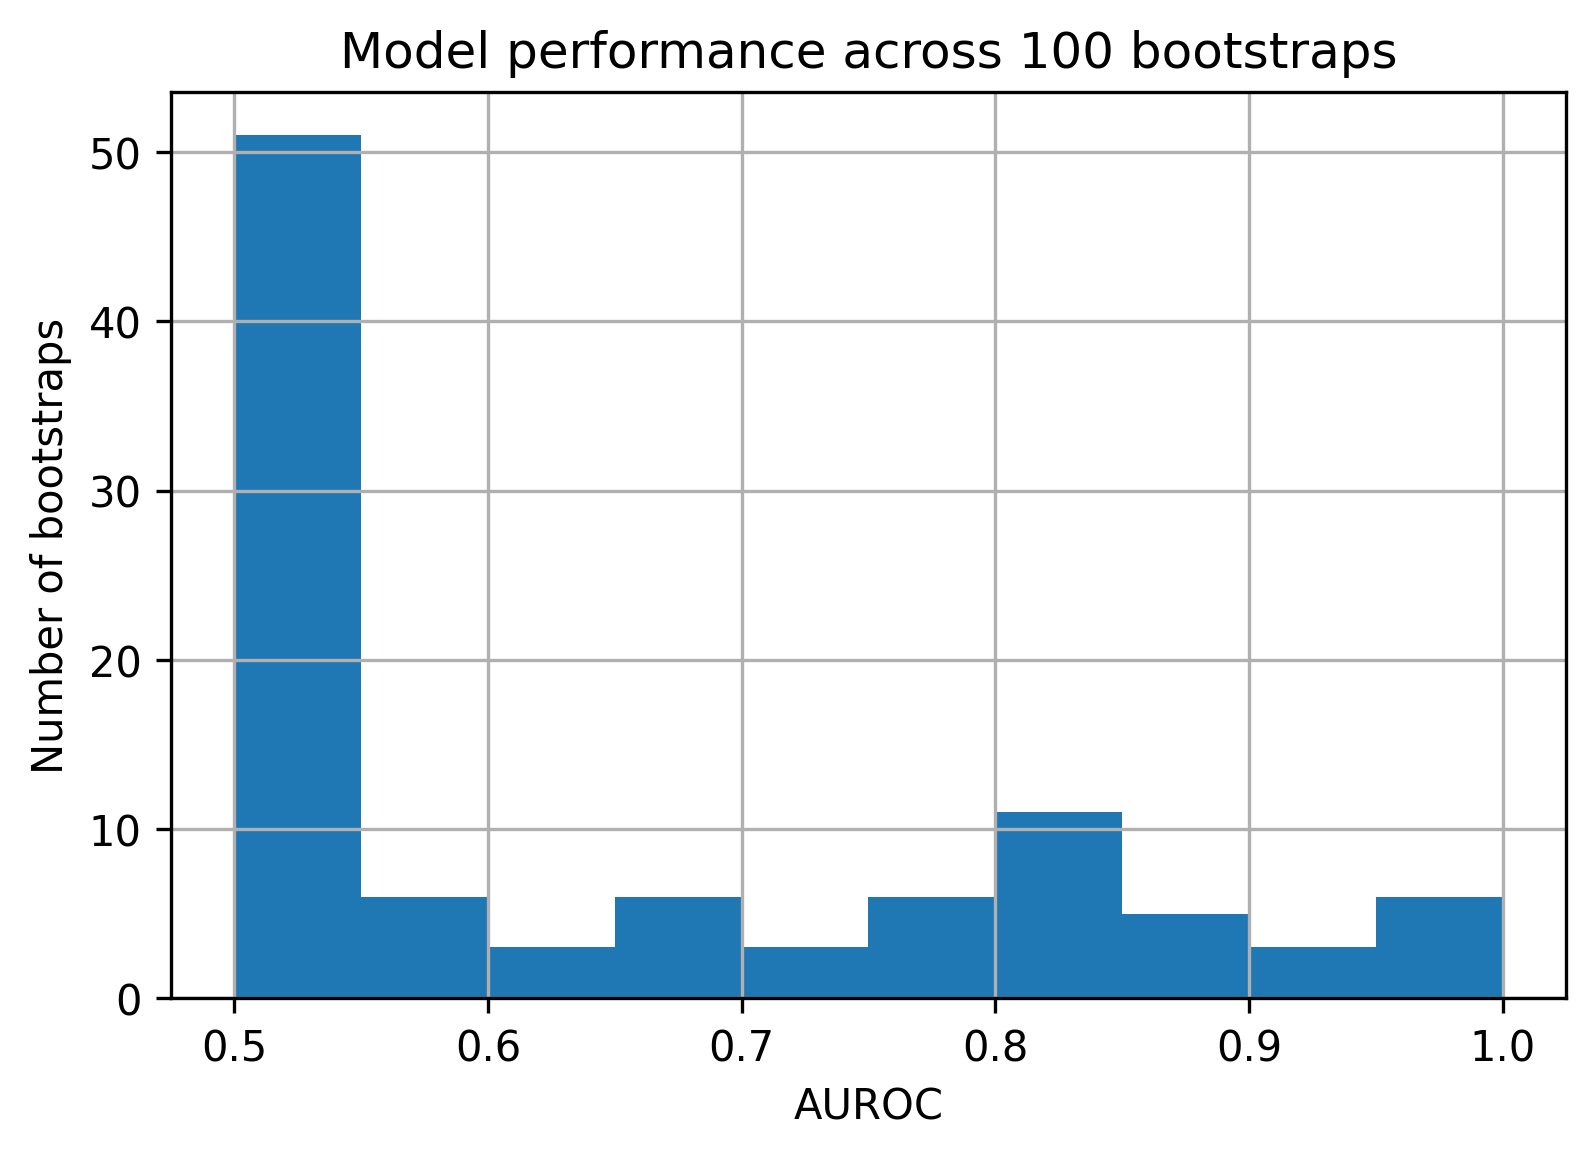

In [87]:
fig,ax = plt.subplots(dpi=300)
perf.groupby(['model'])['test_roc_auc'].hist(ax=ax)
ax.set_xlabel('AUROC')
ax.set_ylabel('Number of bootstraps')
ax.set_title('Model performance across '+str(nboot)+' bootstraps')

Text(0.5, 1.0, 'Model permuted performance across 100 bootstraps')

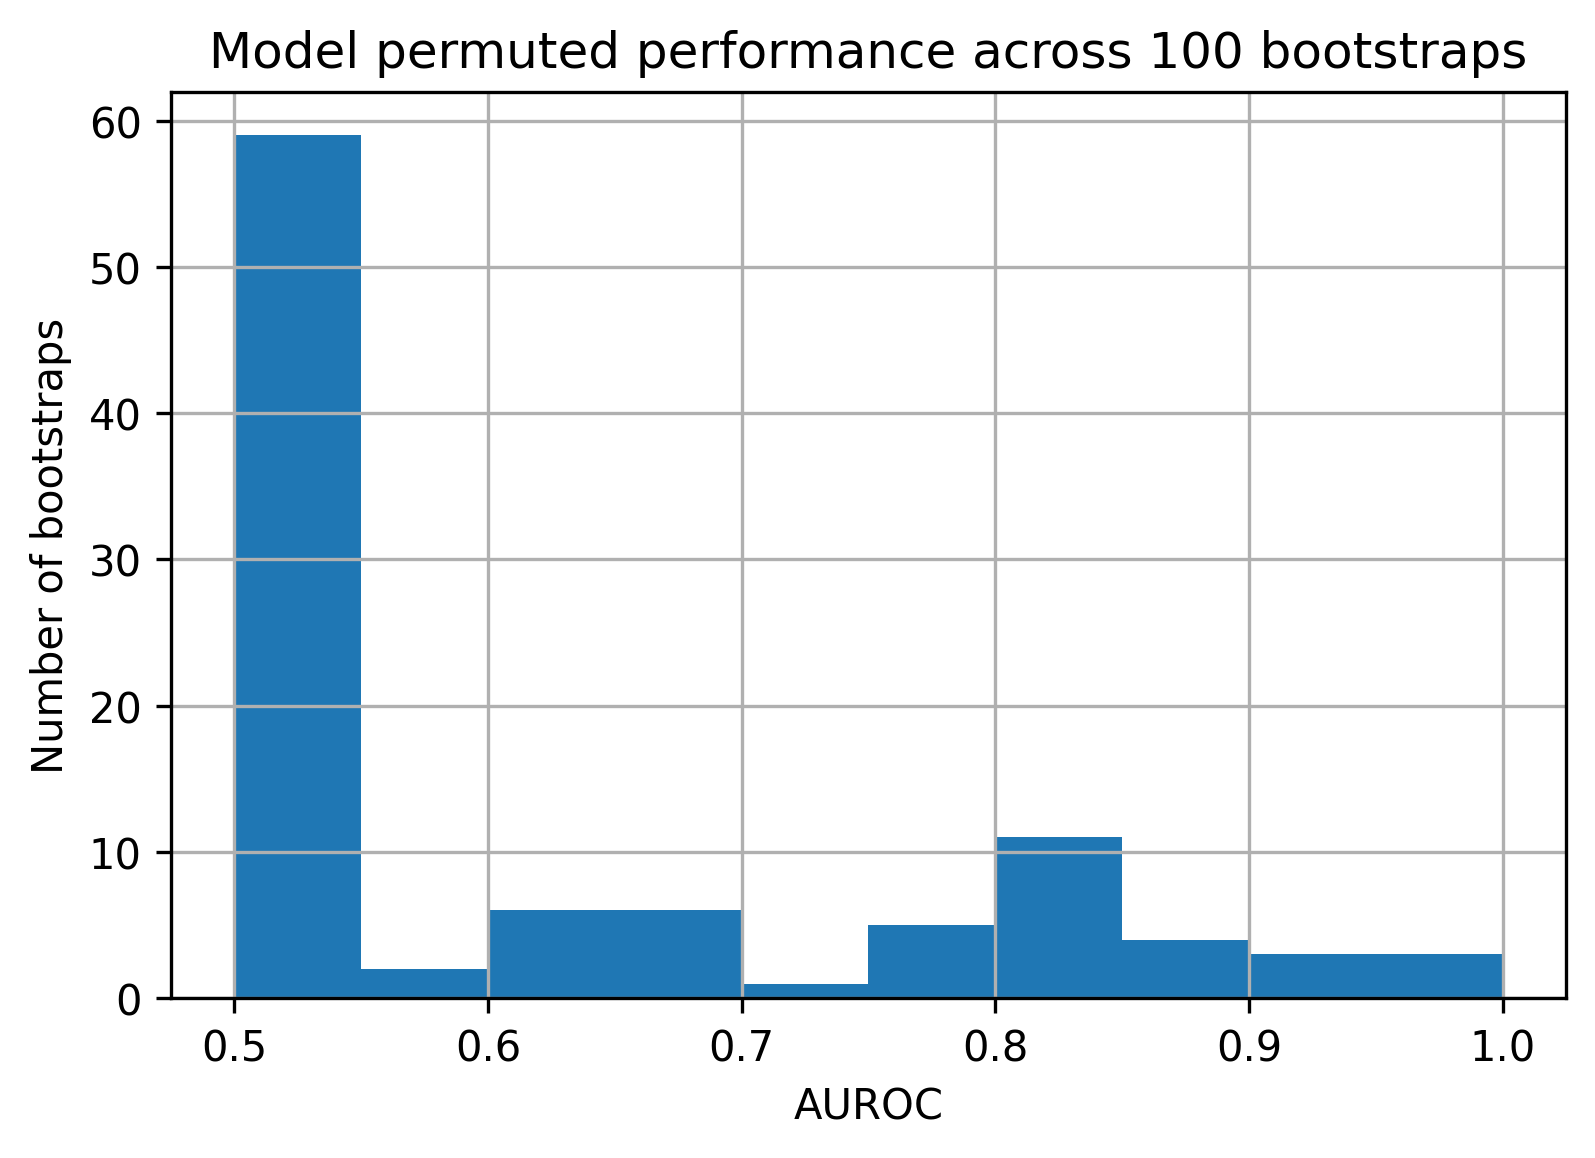

In [88]:
fig,ax = plt.subplots(dpi=300)
pperf.groupby(['model'])['test_roc_auc'].hist(ax=ax)
ax.set_xlabel('AUROC')
ax.set_ylabel('Number of bootstraps')
ax.set_title('Model permuted performance across '+str(nboot)+' bootstraps')

## MCCV feature importance

Text(0.5, 1.0, 'Biomarker importance across 100 bootstraps')

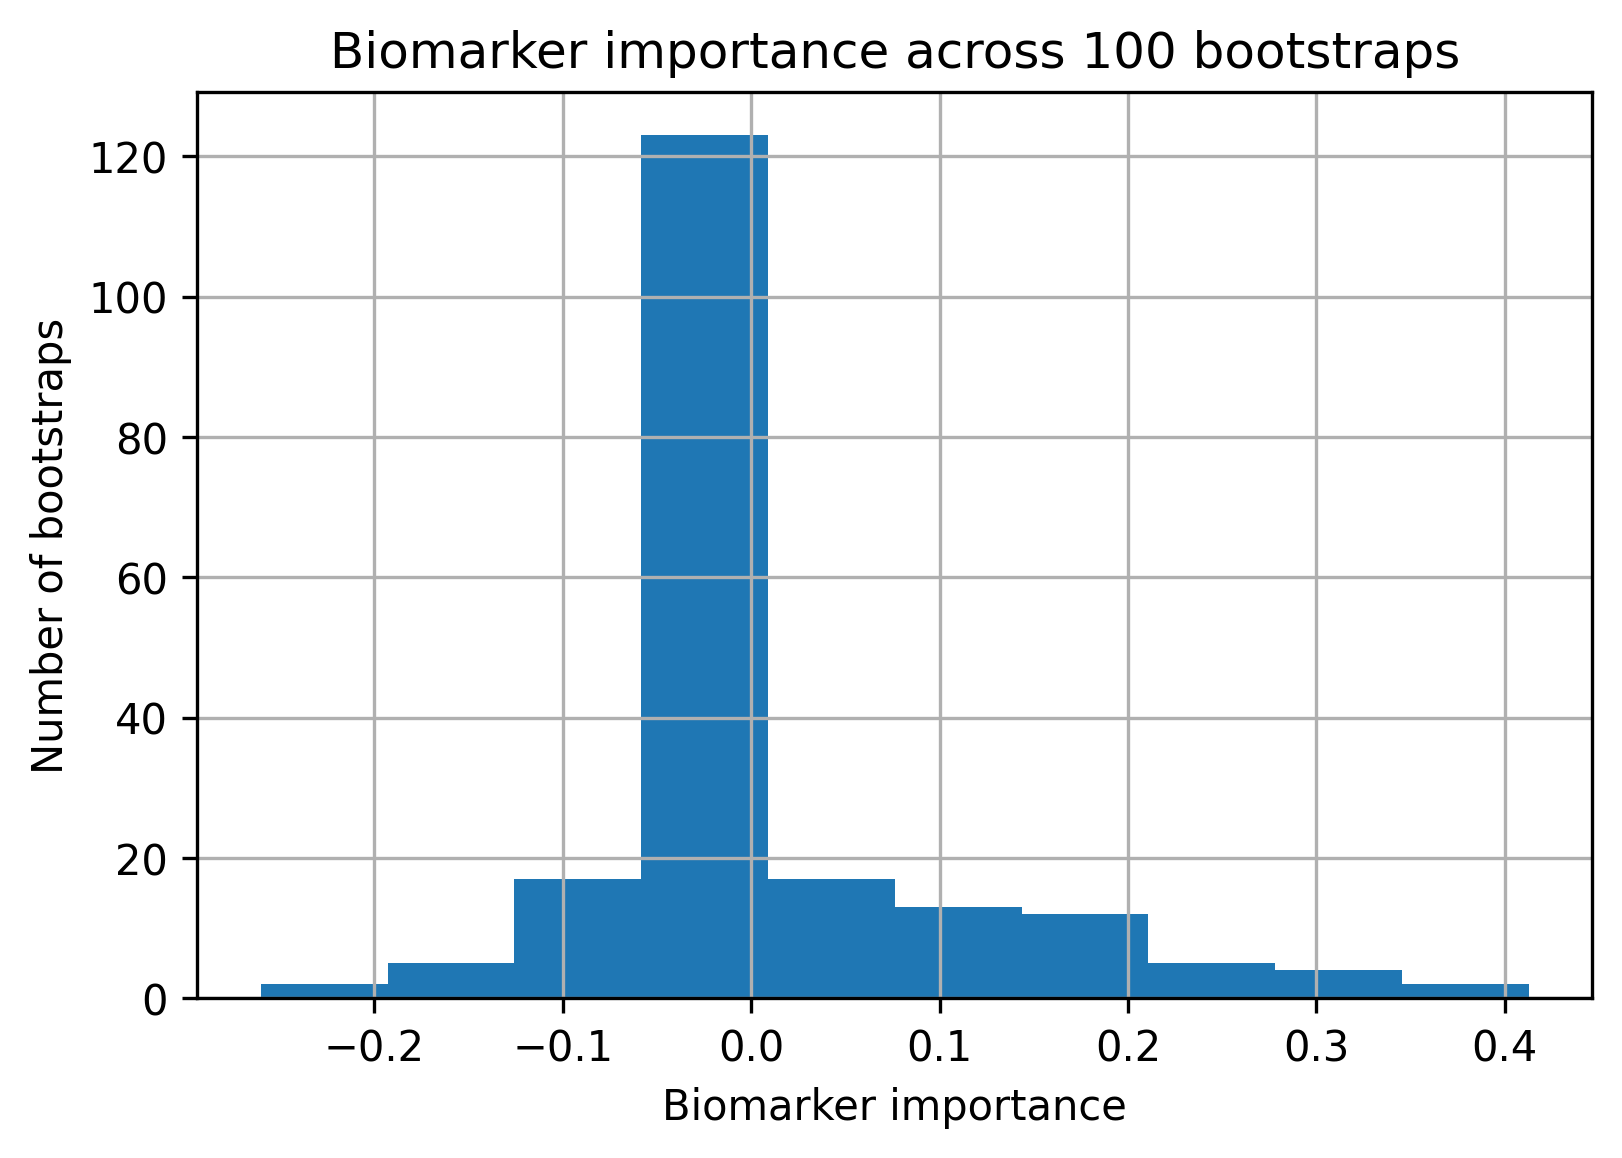

In [89]:
fig,ax = plt.subplots(dpi=300)
fimp.groupby(['model'])['importance'].hist(ax=ax)
ax.set_xlabel('Biomarker importance')
ax.set_ylabel('Number of bootstraps')
ax.set_title('Biomarker importance across '+str(nboot)+' bootstraps')

Text(0.5, 1.0, 'Biomarker permuted importance across 100 bootstraps')

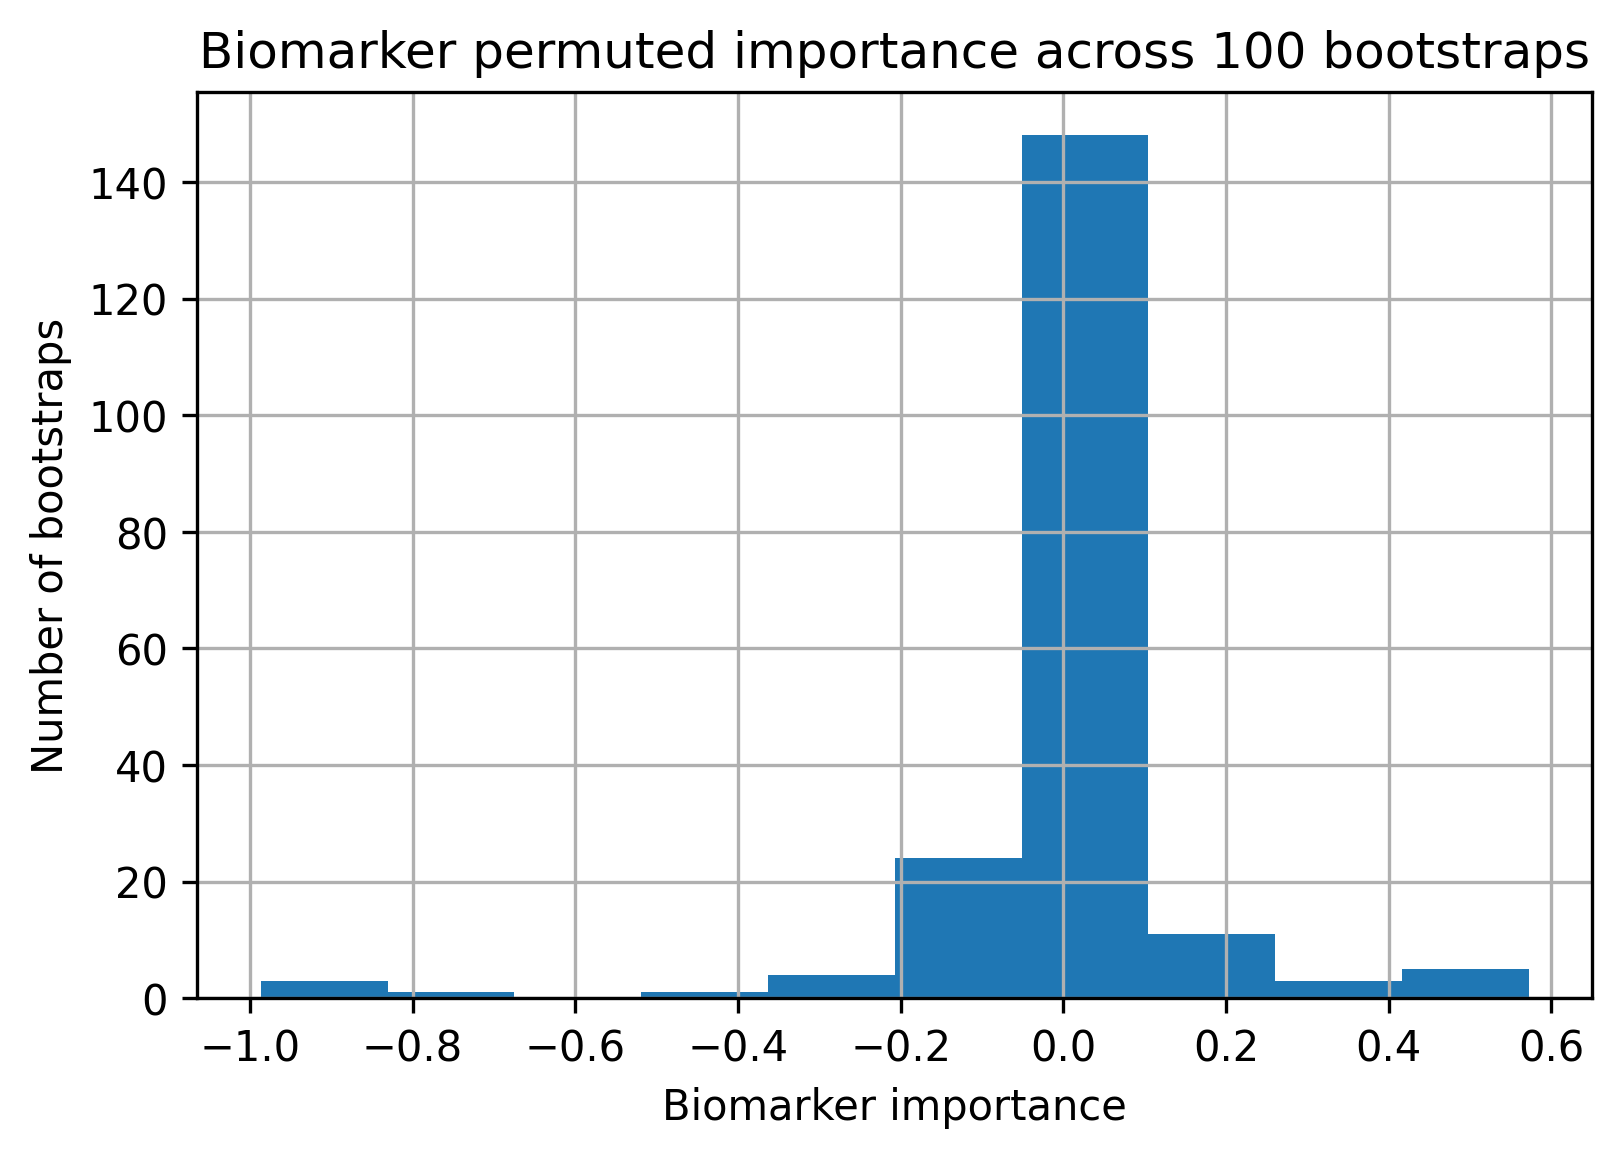

In [90]:
fig,ax = plt.subplots(dpi=300)
pfimp.groupby(['model'])['importance'].hist(ax=ax)
ax.set_xlabel('Biomarker importance')
ax.set_ylabel('Number of bootstraps')
ax.set_title('Biomarker permuted importance across '+str(nboot)+' bootstraps')

## MCCV patient prediction

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Estimated AUROC prediction')

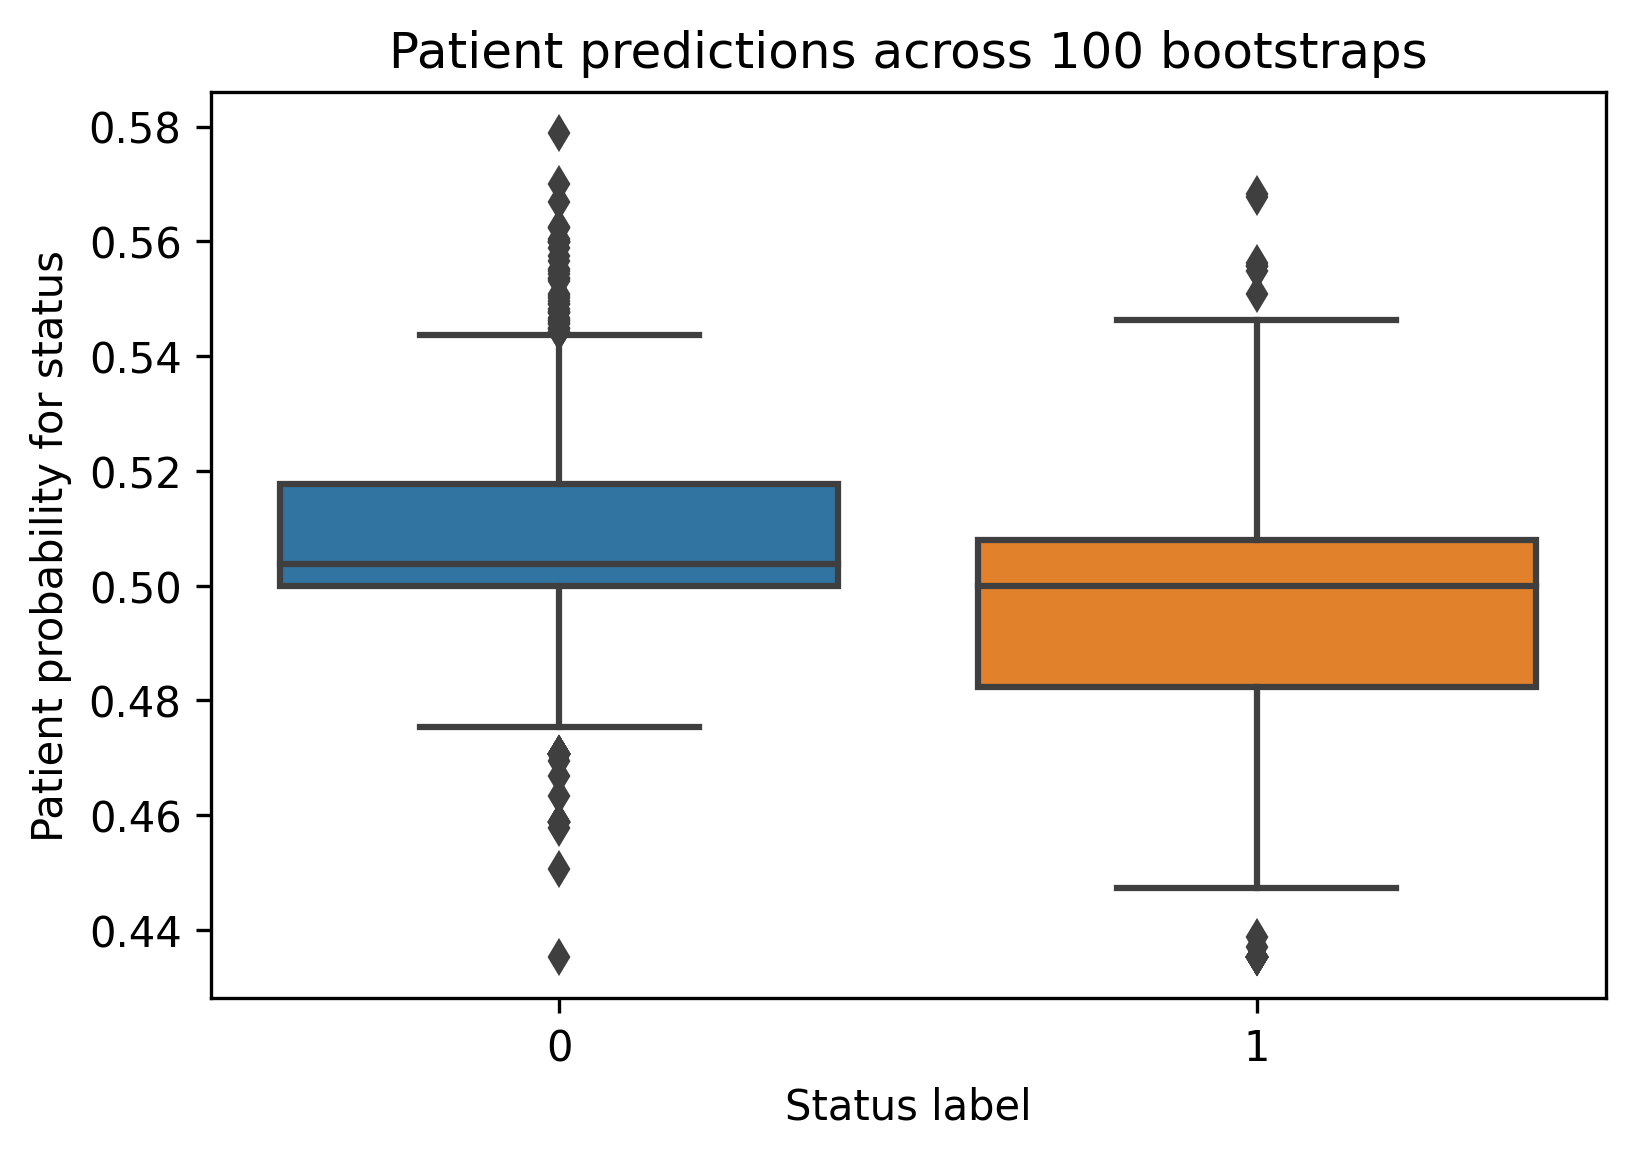

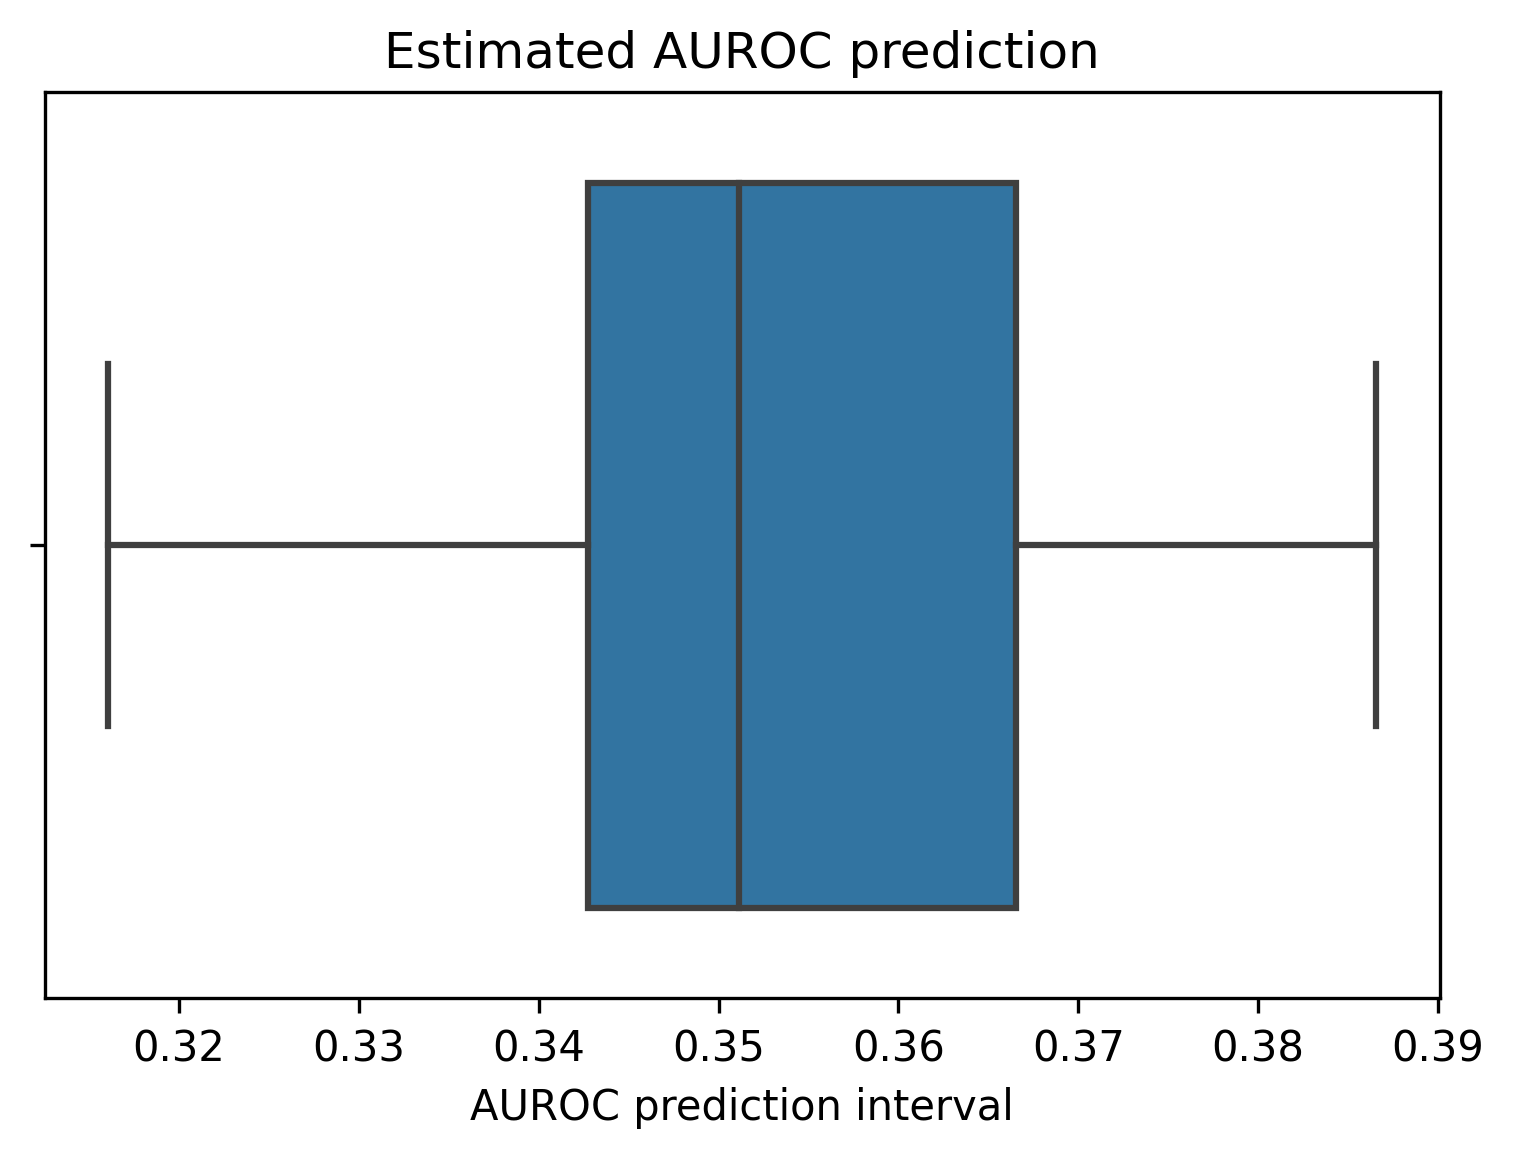

In [91]:
fig,ax = plt.subplots(dpi=300)
sns.boxplot('y_true','y_proba',data=ppreds,ax=ax)
ax.set_xlabel('Status label')
ax.set_ylabel('Patient probability for status')
ax.set_title('Patient predictions across '+str(nboot)+' bootstraps')

fig,ax = plt.subplots(dpi=300)
sns.boxplot(ppreds_scores['roc_auc'],ax=ax)
ax.set_xlabel('AUROC prediction interval')
ax.set_title('Estimated AUROC prediction')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Estimated AUROC permuted prediction')

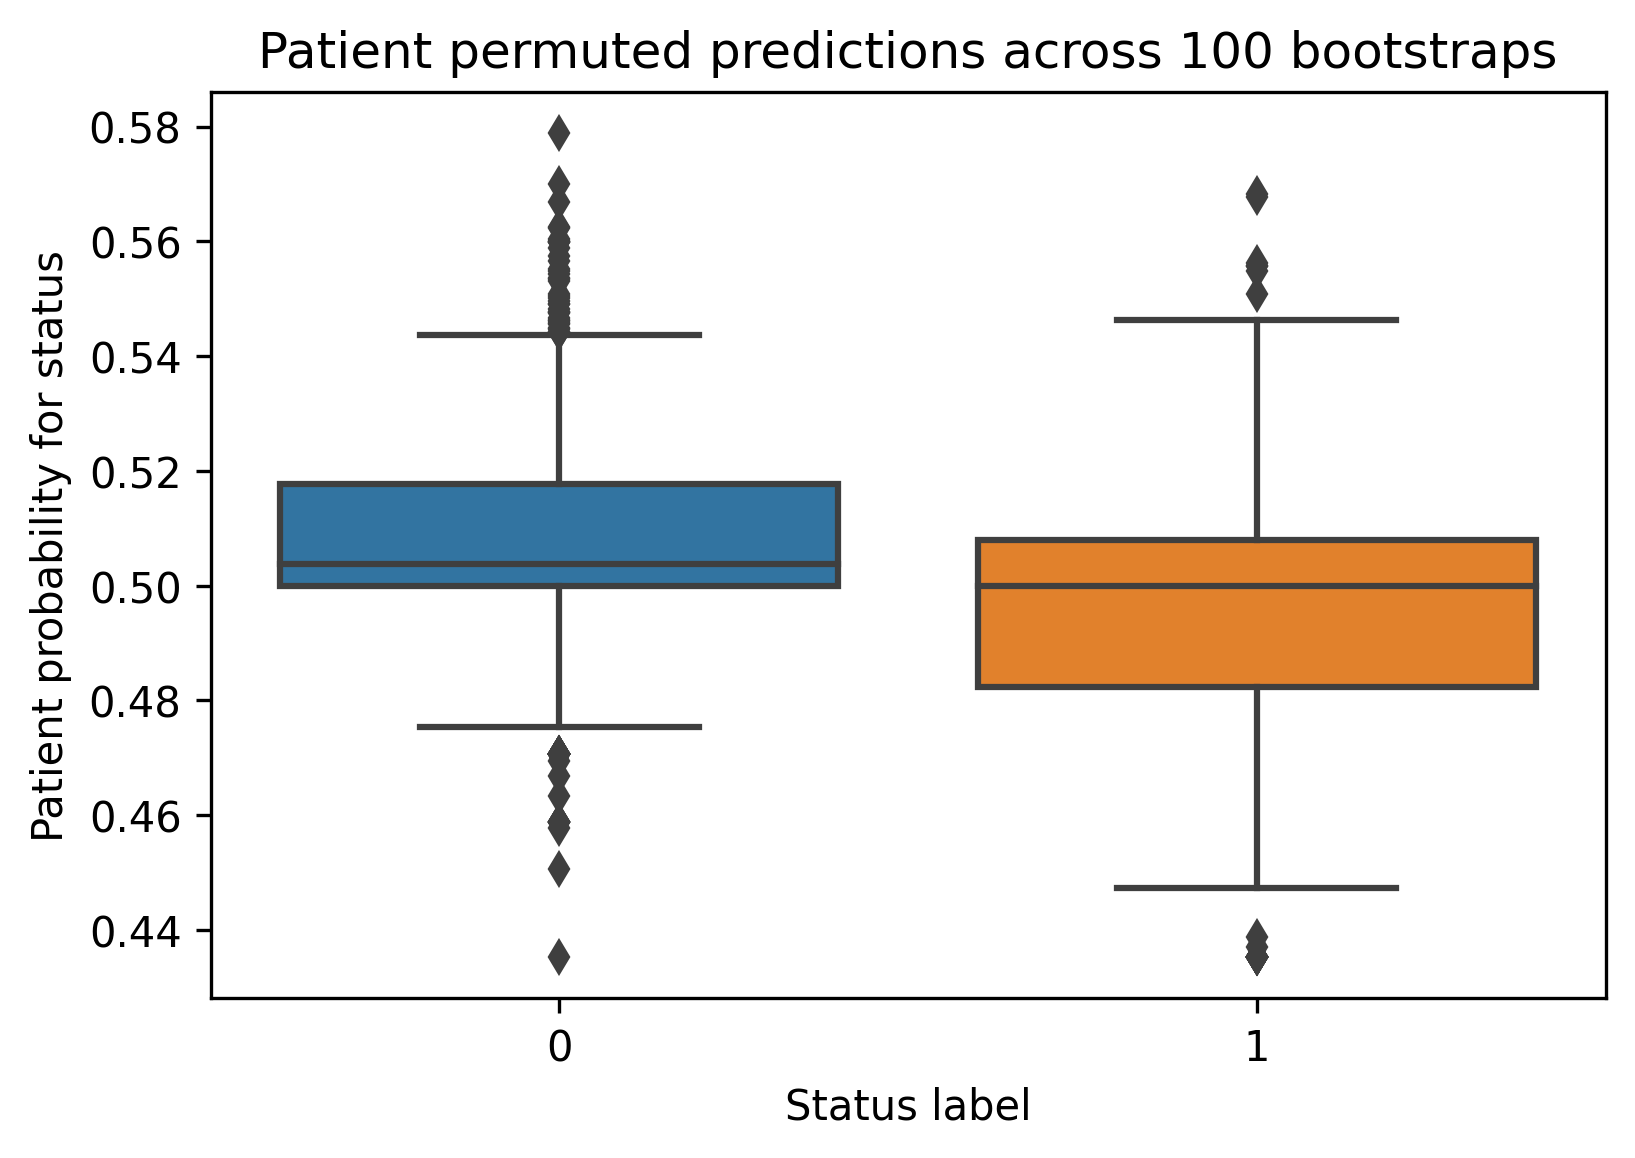

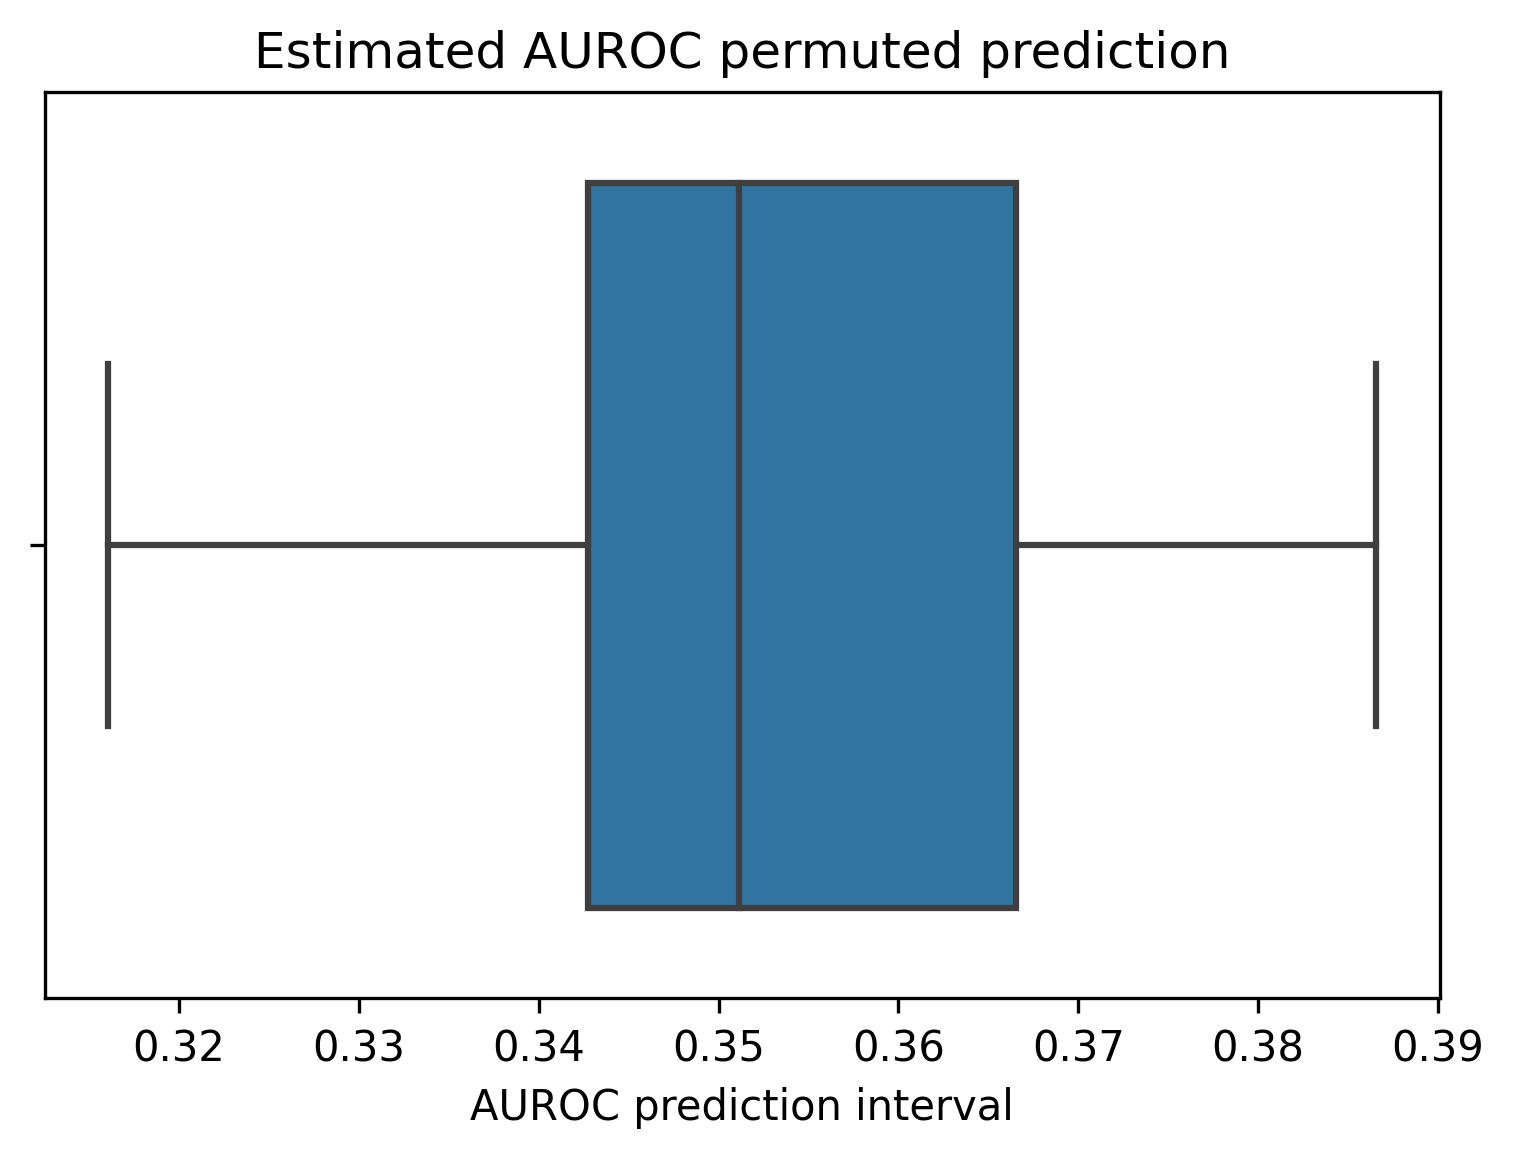

In [92]:
fig,ax = plt.subplots(dpi=300)
sns.boxplot('y_true','y_proba',data=pppreds,ax=ax)
ax.set_xlabel('Status label')
ax.set_ylabel('Patient probability for status')
ax.set_title('Patient permuted predictions across '+str(nboot)+' bootstraps')

fig,ax = plt.subplots(dpi=300)
sns.boxplot(pppreds_scores['roc_auc'],ax=ax)
ax.set_xlabel('AUROC prediction interval')
ax.set_title('Estimated AUROC permuted prediction')

# mccv class

In [8]:
import numpy as np
import pandas as pd
from sklearn import linear_model, model_selection, ensemble
from sklearn import svm
from sklearn.base import clone
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold
from joblib import Parallel, delayed
from sklearn.base import clone
from sklearn.utils import shuffle
import sys

class mccv(object):
	"""
	Monte carlo cross validation results

	Dataframes, variables, and functions facilitating the processing, analysis, and results from the MCCV routine.

	Parameters
	----------
	cv_split: int
		Number of splits for cross validation.

	test_size: float
			Number between 0 and 1 for the proportinal size of the dataset for testing the trained machine learning model.

    n_jobs: int
    	Number of cores to be used for parallel processing.

    seed: int
    	Number to set random number seed generators.

    Examples
    --------


	"""

	def __init__(self,num_bootstraps = 1,n_jobs = 2):

		######
		# SET ARGUMENTS
		self.X = None,
		self.Y = None,
		self.all_models = {}
		self.model_names = ['Logistic Regression']
		self.num_bootstraps = num_bootstraps
		self.cv_split = 10
		self.test_size = 0.15
		self.n_jobs = n_jobs
		self.metrics=['roc_auc']
		self.return_train_score = True
		self.return_estimator = True
		self.seed = 0
		######

		######
		# INSTANTIATE MODELS AND PREPARE MODELS TO BE USED
		self._set_models()
		if type(self.model_names)==str:
			self.model_names = [x for x in [self.model_names] if x in self.all_models]
		if type(self.model_names)==list:
			self.model_names = [x for x in self.model_names if x in self.all_models]
			if len(self.model_names)==0:
				sys.exit('Please enter a prespecified model name(s) as a list: "Logistic Regression", "Random Forest", "Support Vector Machines", and/or "Gradient Boosting Machines"')
		######


		######
		# INSTANTIATE DATA OBJECT HOLDERS
		self.mccv_data = None
		self.mccv_permuted_data = None
		######

		######
		# make sure given metrics are in list and not one metric given as a string
		if type(self.metrics)==str:
			self.metrics = [x for x in [self.metrics] if x in metrics.SCORERS.keys()]
		if type(self.metrics)==list:
			self.metrics = [x for x in self.metrics if x in metrics.SCORERS.keys()]
			if len(self.metrics)==0:
				sys.exit('Please enter a metric name from sklearn.metrics.SCORERS.keys()')
		if type(self.metrics) not in [str,list]:
			sys.exit('Please enter a metric name from sklearn.metrics.SCORERS.keys()')
		######

	def set_X(self,X):
		"""
		Set the data for the learning task (i.e. predictors)

		Parameters
		----------
		X: dataframe
			A pandas dataframe indexed by the unique observations and columns as the predictors

		"""
		self.X = X

	def set_Y(self,Y):
		"""
		Set the data for the learning task (i.e. response)

		Parameters
		----------
		Y: dataframe
			A pandas dataframe indexed by the unique observations and column as the response
			
		"""
		self.Y = Y

	def _set_models(self):
		"""
		Set the machine learning models to  choose from

		Parameters
		----------
		See sklearn guides for details on parameters:
		- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
		- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
		- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
		- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

		"""

		self.all_models = {
		  "Logistic Regression" : linear_model.LogisticRegression(
			  C=1,
			  penalty='l1',
			  solver='liblinear',
			  tol=1e-3,
			  random_state=self.seed),
		  "Random Forest" : ensemble.RandomForestClassifier(
			  criterion='gini',
			  max_depth=1,
			  max_features='log2',
			  min_samples_leaf=2,
			  min_samples_split=2,
			  n_estimators=100,
			  oob_score=True,
			  n_jobs=self.n_jobs,
			  random_state=self.seed),
		  "Support Vector Machine" : svm.SVC(
			  C=1,
			  kernel='linear',
			  random_state=self.seed,
			  probability=True,
			  tol=1e-3),
		  "Gradient Boosting Classifier" : ensemble.GradientBoostingClassifier(
			  n_estimators=100,
			  learning_rate=0.1,
			  max_depth=1,
			  max_features='log2',
			  min_samples_leaf=2,
			  min_samples_split=2,
			  random_state=self.seed)
		 }

	def _get_models(self):
		"""
		Get models based on model name(s) 

		Parameters
		----------
		NULL

		"""
		dict_ = {}
		for m in self.model_names:
			dict_[m] = self.all_models[m]
		return dict_

	def mccv(self,seed):
		"""
		Monte Carlo Cross Validation routine


		Parameters
		----------
		seed: int
			Random seed for random number generator

		"""
		# 1/ train and test split
		Y = self.Y
		X = self.X.loc[Y.index]
		X_train, X_test, y_train, y_test = train_test_split(X,Y,
	                                                            test_size=self.test_size,
	                                                            random_state=seed,
	                                                            shuffle=True)
		X_train = X_train.apply(lambda x : (x - min(x))/(max(x) - min(x)),axis=0)
		X_test = X_test.apply(lambda x : (x - min(x))/(max(x) - min(x)),axis=0)
		X_train[X_train.isna()]=0
		X_test[X_test.isna()]=0
		#define K fold splitter
		cv = StratifiedKFold(n_splits=self.cv_split,random_state=seed,shuffle=True)
		#Instantiate lists to collect prediction and model results
		dfs = []
		model_retrained_fits = {}
		model_confs = []
		#iterate through model dictionary
		for name,mod in self._get_models().items():
			# /2 generate model parameters and fold scores with cv splitter
			fit = cross_validate(clone(mod),X_train,y_train.values.reshape(1,-1)[0],cv=cv,scoring=self.metrics,
									n_jobs=1,return_train_score=self.return_train_score,
									return_estimator=self.return_estimator)
			tmp = pd.DataFrame({'fold' : range(self.cv_split),
	                                    'model' : name},
	                                   index=range(self.cv_split))
			#populate scores in dataframe
			cols = [k for k in fit.keys() if (k.find('test')+k.find('train'))==-1]
			for col in cols:
				tmp[col] = fit[col]
			# /3 Identify best performing model
			top_fold = np.where(fit['test_roc_auc']==fit['test_roc_auc'].max())[0][0]
			keys = [x for x in  fit.keys()]
			vals = [fit[x][top_fold] for x in keys]
			top_model_key_vals = {}
			for i in range(len(vals)):
				top_model_key_vals[keys[i]] = vals[i]
			#4/ train models on training set 
			# also get sample level predictions
			f = top_model_key_vals['estimator']
			fitted = clone(f).fit(X_train,y_train.values.reshape(1,-1)[0])
			conf = pd.DataFrame({'y_true' : y_test.values.reshape(1,-1)[0],
	                                     'y_pred' : fitted.predict(X_test),
	                                     'y_proba' : fitted.predict_proba(X_test)[:,1],
	                                     'bootstrap' : np.repeat(seed,len(y_test.index)),
	                                     'model' : np.repeat(name,len(y_test.index))},
	                                    index=y_test.index)
			model_confs.append(conf)
			#do prediction for each metric
			for metric in self.metrics:
				tmp['validation_'+metric] = metrics.SCORERS[metric](fitted,X_test,y_test)
			model_retrained_fits[name] = fitted
			dfs.append(tmp.query('fold==@top_fold').drop('fold',1))
		return pd.concat(dfs,sort=True).reset_index(drop=True), model_retrained_fits, pd.concat(model_confs,sort=True)

	def _permute_Y(self,seed):
		"""
		Shuffle Y values

		Parameters:
		----------
		Y : pandas series
			Index of samples and values are their class labels
		seed : int
			Random seed for random number generator
		Returns:
		------
		arr_shuffle: pandas series
			A shuffled Y
		"""
		arr = shuffle(self.Y.values,random_state=seed)
		arr_shuffle = (pd.Series(arr.reshape(1,-1)[0],index=self.Y.index))
		return arr_shuffle

	def permuted_mccv(self,seed):
		"""
		Monte Carlo Cross Validation permutation routine


		Parameters
		----------
		seed: int
			Random seed for random number generator

		"""
		X = self.X.loc[self.Y.index]
		Y_shuffle = self._permute_Y(seed=seed)
		X_shuffle = X.loc[Y_shuffle.index]
		# 1/ train and test split
		X = X_shuffle.loc[Y_shuffle.index]
		X_train, X_test, y_train, y_test = train_test_split(X_shuffle,Y_shuffle,
	                                                            test_size=self.test_size,
	                                                            random_state=seed,
	                                                            shuffle=True)
		X_train = X_train.apply(lambda x : (x - min(x))/(max(x) - min(x)),axis=0)
		X_test = X_test.apply(lambda x : (x - min(x))/(max(x) - min(x)),axis=0)
		X_train[X_train.isna()]=0
		X_test[X_test.isna()]=0
		#define K fold splitter
		cv = StratifiedKFold(n_splits=self.cv_split,random_state=seed,shuffle=True)
		#Instantiate lists to collect prediction and model results
		dfs = []
		model_retrained_fits = {}
		model_confs = []
		#iterate through model dictionary
		for name,mod in self._get_models().items():
			# /2 generate model parameters and fold scores with cv splitter
			fit = cross_validate(clone(mod),X_train,y_train.values.reshape(1,-1)[0],cv=cv,scoring=self.metrics,
									n_jobs=1,return_train_score=self.return_train_score,
									return_estimator=self.return_estimator)
			tmp = pd.DataFrame({'fold' : range(self.cv_split),
	                                    'model' : name},
	                                   index=range(self.cv_split))
			#populate scores in dataframe
			cols = [k for k in fit.keys() if (k.find('test')+k.find('train'))==-1]
			for col in cols:
				tmp[col] = fit[col]
			# /3 Identify best performing model
			top_fold = np.where(fit['test_roc_auc']==fit['test_roc_auc'].max())[0][0]
			keys = [x for x in  fit.keys()]
			vals = [fit[x][top_fold] for x in keys]
			top_model_key_vals = {}
			for i in range(len(vals)):
				top_model_key_vals[keys[i]] = vals[i]
			#4/ train models on training set 
			# also get sample level predictions
			f = top_model_key_vals['estimator']
			fitted = clone(f).fit(X_train,y_train.values.reshape(1,-1)[0])
			conf = pd.DataFrame({'y_true' : y_test.values.reshape(1,-1)[0],
	                                     'y_pred' : fitted.predict(X_test),
	                                     'y_proba' : fitted.predict_proba(X_test)[:,1],
	                                     'bootstrap' : np.repeat(seed,len(y_test.index)),
	                                     'model' : np.repeat(name,len(y_test.index))},
	                                    index=y_test.index)
			model_confs.append(conf)
			#do prediction for each metric
			for metric in self.metrics:
				tmp['validation_'+metric] = metrics.SCORERS[metric](fitted,X_test,y_test)
			model_retrained_fits[name] = fitted
			dfs.append(tmp.query('fold==@top_fold').drop('fold',1))
		return pd.concat(dfs,sort=True).reset_index(drop=True), model_retrained_fits, pd.concat(model_confs,sort=True)

	def _get_performance(self,lst):
		"""
		Extract model performance statistics from mccv data

		Parameters
		----------
		lst: list
			List of mccv data
		"""
		perf = (pd.
				concat(lst,keys=range(len(lst))).
				reset_index(level=1,drop=True).
				rename_axis('bootstrap').
				reset_index()
				)
		return perf

	def _model_feature_importances(self,boot_mods):
		"""
		Extract feature performance statistics from mccv data (top performing model from cross validation)

		Parameters
		----------
		lst: list
			List of models used in mccv routine
		"""
		dfs = []
		X = self.X.copy()
		X.loc[:,'Intercept'] = 0
		for i in range(len(boot_mods)):
			for j in boot_mods[i].keys():
				mod = boot_mods[i][j]
				coef = []
				try:
					coef.extend([i for i in mod.feature_importances_])
				except:
					coef.extend([i for i in mod.coef_[0]])
				try:
					coef.extend(mod.intercept_)
				except:
					coef.extend([np.nan])
				fs = []
				fs.extend(X.columns.values)
				df = pd.DataFrame({
					'feature' : fs,
					'importance' : coef,
					'model' : j,
					'bootstrap' : i
				})
				dfs.append(df)
		return pd.concat(dfs,sort=True)

	def _patient_predictions(self,lst,n=50):
		"""
		Extract performance statistics from mccv patient data

		Parameters
		----------
		lst: list
			List of mccv data
		n: int
			Number of bootstraps of validation data
		"""
		dat = \
		(pd.
		 concat(
		 	lst
		 	)
		 )
		score_vals = []
		for model in dat.model.unique():
			model_dat = dat[dat.model==model]
			for score in self.metrics:
				for b in range(n):
					x = (model_dat.
						sample(n=model_dat.shape[0],replace=True,random_state=b)
						)
					score_vals.append([model,score,b,metrics.SCORERS[score]._score_func(x.y_true,x.y_proba)])
		return dat, pd.DataFrame(score_vals,columns=['model','metric','performance_bootstrap','value'])

	def _bootstrap_of_function(self,func,params={}):
		"""
		Parallel routine for computing MCCV

		Parameters
		----------
		func: function
			Function to perform in parallel
		params: dictionary
			Dictionary of arguments for parallelized funcction. Currently not used.
		"""
		if func==None:
			return "Need function to bootstrap"
		parallel = Parallel(n_jobs=self.n_jobs)
		return parallel(
			delayed(func)(seed=k,**params) for k in range(self.num_bootstraps)
			)

	def run_mccv(self):
		"""
		Wrapper to compute and extract statistics from MCCV routine

		Parameters
		----------
		NULL

		"""

		lst = self._bootstrap_of_function(func=self.mccv)

		perf = self._get_performance([lst[i][0] for i in range(self.num_bootstraps)])

		boot_mods = [lst[i][1] for i in range(self.num_bootstraps)]
		fimp = self._model_feature_importances(boot_mods)

		tmp = self._patient_predictions([lst[i][2] for i in range(self.num_bootstraps)])
		ppreds = tmp[0]
		ppreds_scores = tmp[1]

		self.mccv_data = {"Model Learning" : perf,"Feature Importance" : fimp, 
							"Patient Predictions" : ppreds,"Performance" : ppreds_scores}

	def run_permuted_mccv(self):
		"""
		Wrapper to comnpute and extract statistics from MCCV permutation routine

		Parameters
		----------
		"""

		lst = self._bootstrap_of_function(func=self.permuted_mccv)

		perf = self._get_performance([lst[i][0] for i in range(self.num_bootstraps)])

		boot_mods = [lst[i][1] for i in range(self.num_bootstraps)]
		fimp = self._model_feature_importances(boot_mods)

		tmp = self._patient_predictions([lst[i][2] for i in range(self.num_bootstraps)])
		ppreds = tmp[0]
		ppreds_scores = tmp[1]

		self.mccv_permuted_data = {"Model Learning" : perf,"Feature Importance" : fimp, 
									"Patient Predictions" : ppreds,"Performance" : ppreds_scores}





In [9]:
X = data[['biomarker']]
Y = data[['status']]
display(X.head())
Y

,biomarker
obs,
1,1.665731
2,-0.875837
3,-1.391374
4,-0.297352
5,0.189857


,status
obs,
1,0
2,0
3,0
4,0
5,1
...,...
96,1
97,1
98,0


In [10]:
mccv_obj = mccv(num_bootstraps=200)

In [11]:
mccv_obj.__dict__

{'X': (None,),
 'Y': (None,),
 'all_models': {'Logistic Regression': LogisticRegression(C=1, penalty='l1', random_state=0, solver='liblinear',
                     tol=0.001),
  'Random Forest': RandomForestClassifier(max_depth=1, max_features='log2', min_samples_leaf=2,
                         n_jobs=2, oob_score=True, random_state=0),
  'Support Vector Machine': SVC(C=1, kernel='linear', probability=True, random_state=0),
  'Gradient Boosting Classifier': GradientBoostingClassifier(max_depth=1, max_features='log2', min_samples_leaf=2,
                             random_state=0)},
 'model_names': ['Logistic Regression'],
 'num_bootstraps': 200,
 'cv_split': 10,
 'test_size': 0.15,
 'n_jobs': 2,
 'metrics': ['roc_auc'],
 'return_train_score': True,
 'return_estimator': True,
 'seed': 0,
 'mccv_data': None,
 'mccv_permuted_data': None}

In [12]:
mccv_obj.model_names = ['Logistic Regression','Random Forest','Support Vector Machine','Gradient Boosting Classifier']

In [13]:
mccv_obj.set_X(X)
mccv_obj.set_Y(Y)

In [14]:
mccv_obj.run_mccv()

In [15]:
mccv_obj.mccv_data.keys()

dict_keys(['Model Learning', 'Feature Importance', 'Patient Predictions', 'Performance'])

In [548]:
mccv_obj.run_permuted_mccv()

Text(0.5, 1.0, 'Model performance across 100 bootstraps')

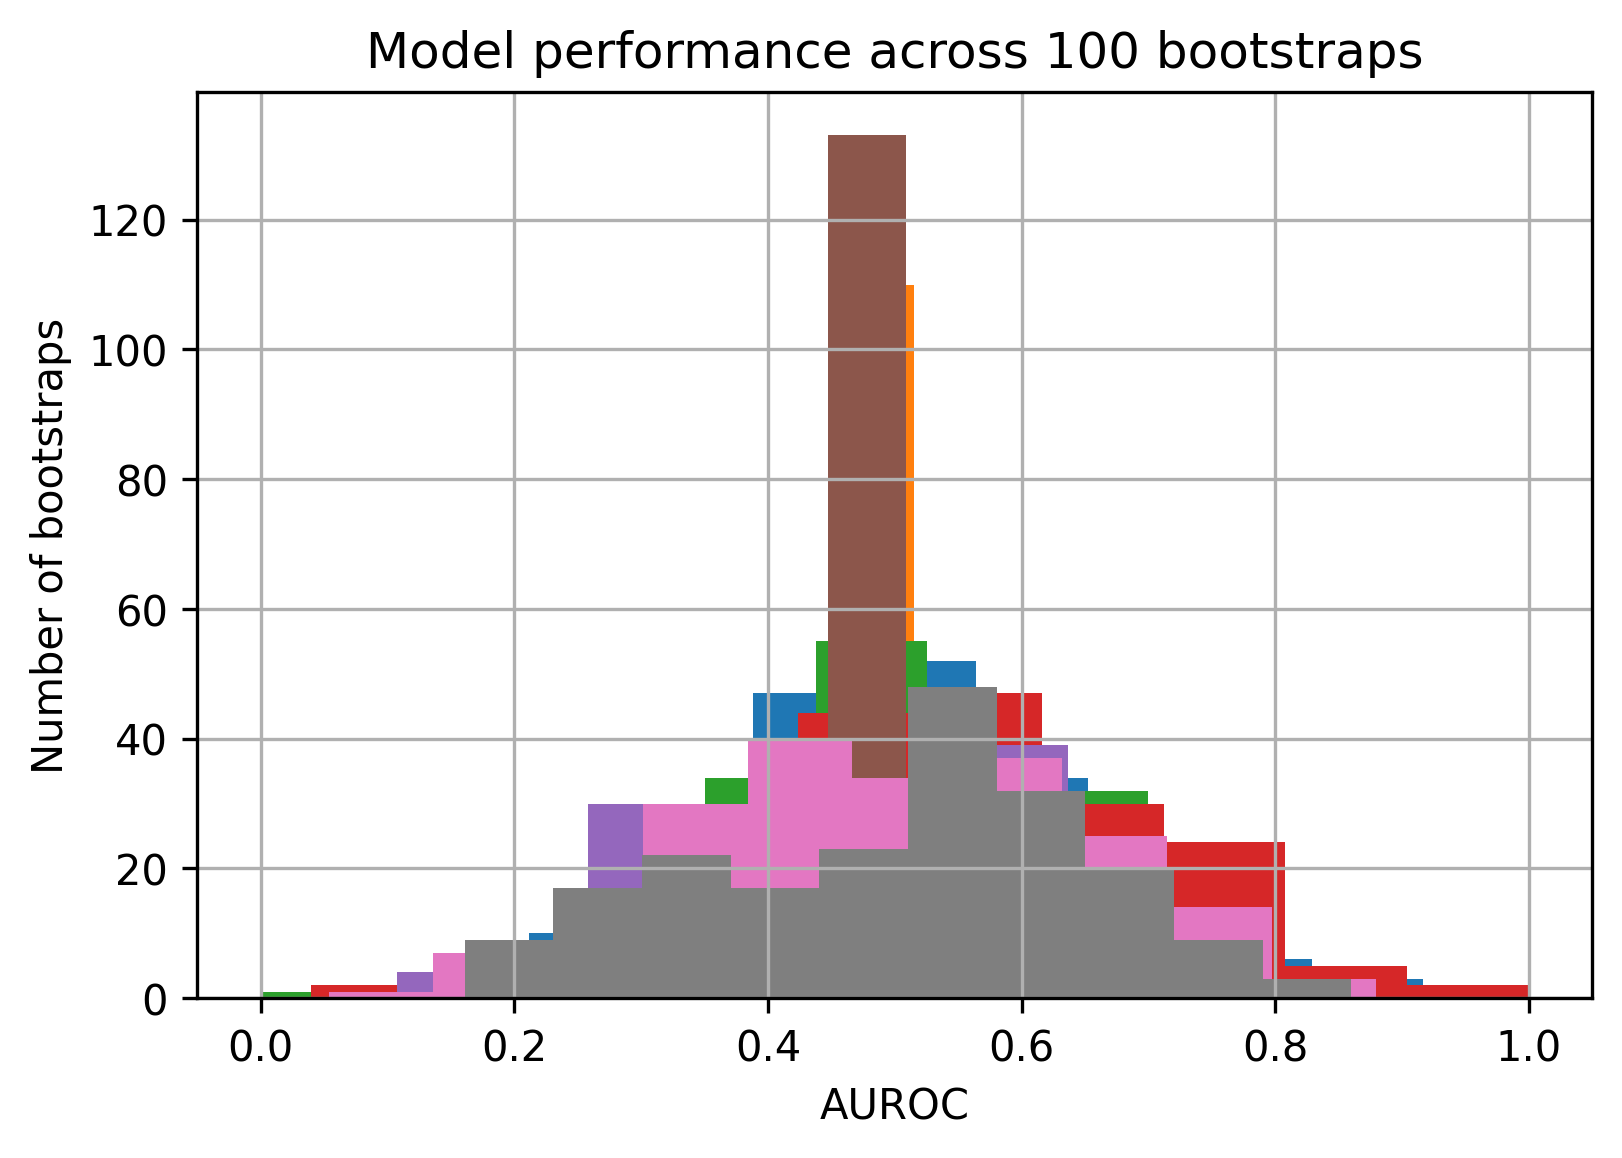

In [549]:
fig,ax = plt.subplots(dpi=300)
mccv_obj.mccv_data['Model Learning'].groupby(['model'])['validation_roc_auc'].hist(ax=ax)
mccv_obj.mccv_permuted_data['Model Learning'].groupby(['model'])['validation_roc_auc'].hist(ax=ax)
ax.set_xlabel('AUROC')
ax.set_ylabel('Number of bootstraps')
ax.set_title('Model performance across '+str(nboot)+' bootstraps')

Text(0.5, 1.0, 'Biomarker permuted importance across 100 bootstraps')

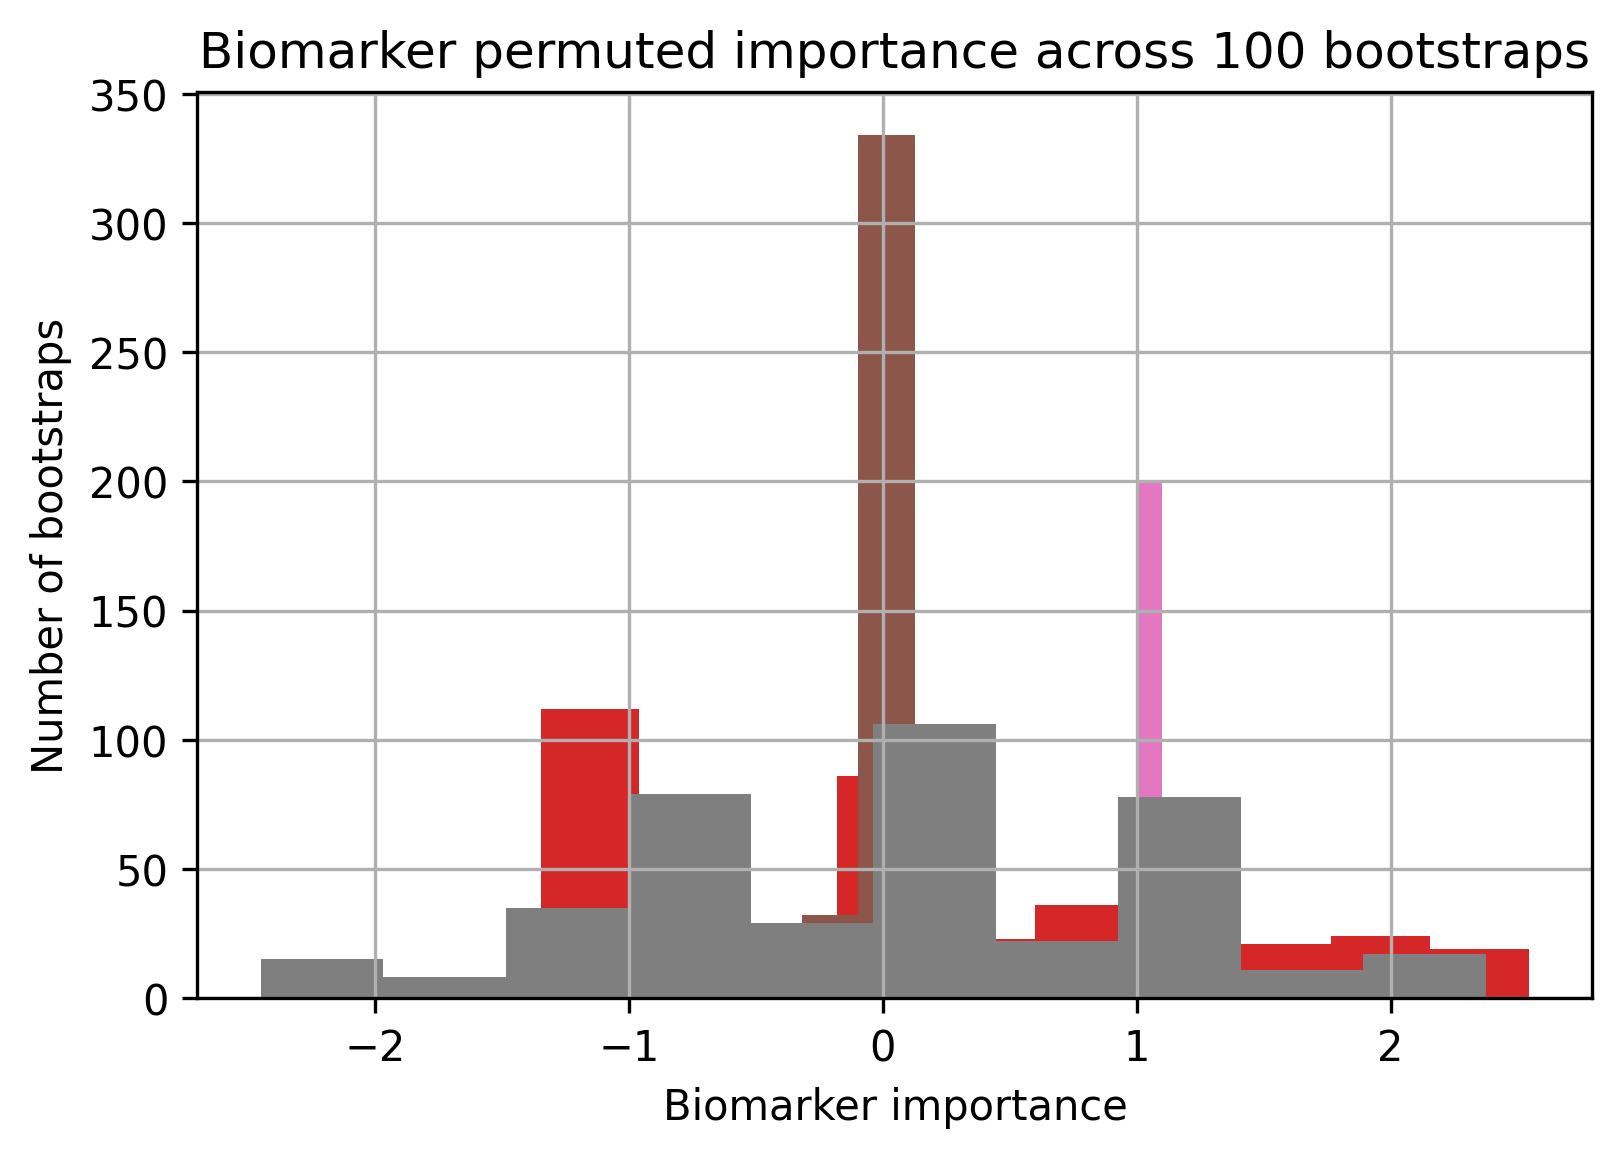

In [550]:
fig,ax = plt.subplots(dpi=300)
mccv_obj.mccv_data['Feature Importance'].groupby(['model'])['importance'].hist(ax=ax)
mccv_obj.mccv_permuted_data['Feature Importance'].groupby(['model'])['importance'].hist(ax=ax)

ax.set_xlabel('Biomarker importance')
ax.set_ylabel('Number of bootstraps')
ax.set_title('Biomarker permuted importance across '+str(nboot)+' bootstraps')

In [551]:
[x for x in mccv_obj.mccv_permuted_data.keys()]

['Model Learning', 'Feature Importance', 'Patient Predictions', 'Performance']

In [552]:
[type(mccv_obj.mccv_permuted_data[x]) for x in mccv_obj.mccv_permuted_data.keys()]

[pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame]

In [554]:
(mccv_obj.
 mccv_permuted_data['Performance'].
 groupby('model')['value'].describe())

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
Gradient Boosting Classifier,50.0,0.462029,0.012163,0.428179,0.453828,0.462128,0.467949,0.487282
Logistic Regression,50.0,0.389479,0.011515,0.367330,0.382978,0.387909,0.395223,0.415115
Random Forest,50.0,0.459896,0.010858,0.436459,0.453826,0.460344,0.466427,0.484956
Support Vector Machine,50.0,0.484232,0.010137,0.460221,0.479323,0.484049,0.491455,0.506692


In [555]:
(mccv_obj.
 mccv_data['Performance'].
 groupby('model')['value'].describe())

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
Gradient Boosting Classifier,50.0,0.468340,0.009513,0.446007,0.462941,0.469469,0.473644,0.488844
Logistic Regression,50.0,0.359163,0.009485,0.340938,0.353348,0.357642,0.364912,0.386963
Random Forest,50.0,0.455389,0.008920,0.439065,0.447743,0.455516,0.459923,0.475890
Support Vector Machine,50.0,0.416884,0.009678,0.393517,0.409232,0.418546,0.424701,0.433593
